<a href="https://colab.research.google.com/github/samhzc/Summer-2025-ECE-597-Group10/blob/main/SPAM_HAM_Evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pickle
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import os
import time
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
train_path = "/content/drive/MyDrive/Collab_Files/SPAM/SPAM_Final_Dataset/train_df.csv"
test_path = "/content/drive/MyDrive/Collab_Files/SPAM/SPAM_Final_Dataset/test_df.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['text'].fillna("", inplace=True)
test_df['text'].fillna("", inplace=True)

/tmp/ipython-input-33-718300420.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['text'].fillna("", inplace=True)
/tmp/ipython-input-33-718300420.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df["text"])
X_test = vectorizer.transform(test_df["text"])

y_train = train_df["label_num"]
y_test = test_df["label_num"]

In [35]:
# Models to evaluate
models = ['NB', 'SVM', 'NN']

# Store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []
pr_aucs = []
sizes = []
times_per_sample = []

# ROC and PR data for plotting
roc_curves = {}
pr_curves = {}

for model in models:
    filename = f'/content/drive/MyDrive/Collab_Files/SPAM/Models/{model}.pkl'
    with open(filename, 'rb') as f:
        loaded_model = pickle.load(f)

    # Accuracy
    y_pred = loaded_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Size (in KB)
    size_kb = os.path.getsize(filename) / 1024
    sizes.append(size_kb)

    # Time per sample
    start = time.time()
    loaded_model.predict(X_test)
    elapsed = time.time() - start
    time_per_sample = elapsed / X_test.shape[0]
    times_per_sample.append(time_per_sample)

    # AUC ROC and PR Curve
    if hasattr(loaded_model, "predict_proba"):
        y_scores = loaded_model.predict_proba(X_test)[:, 1]
    else:
        y_scores = loaded_model.decision_function(X_test)

    roc_auc = roc_auc_score(y_test, y_scores)
    pr_auc = average_precision_score(y_test, y_scores)
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)

    # Save curves
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_scores)
    roc_curves[model] = (fpr, tpr)
    pr_curves[model] = (recall_curve, precision_curve)

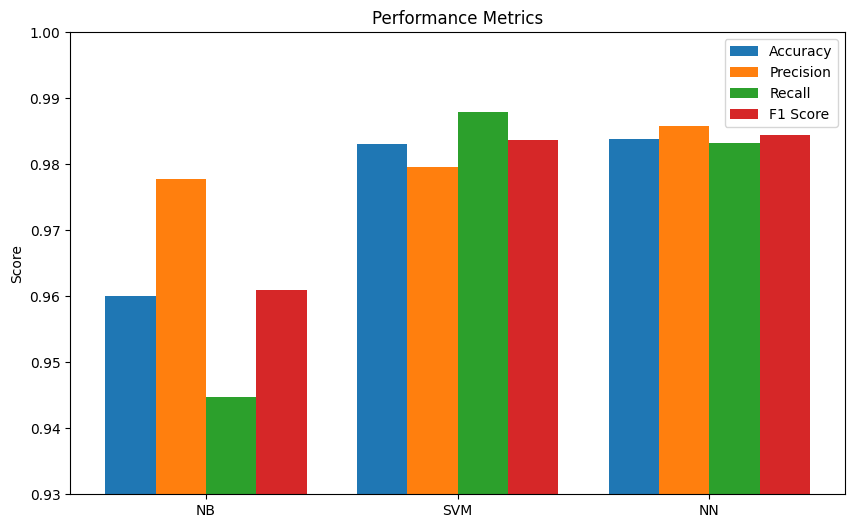

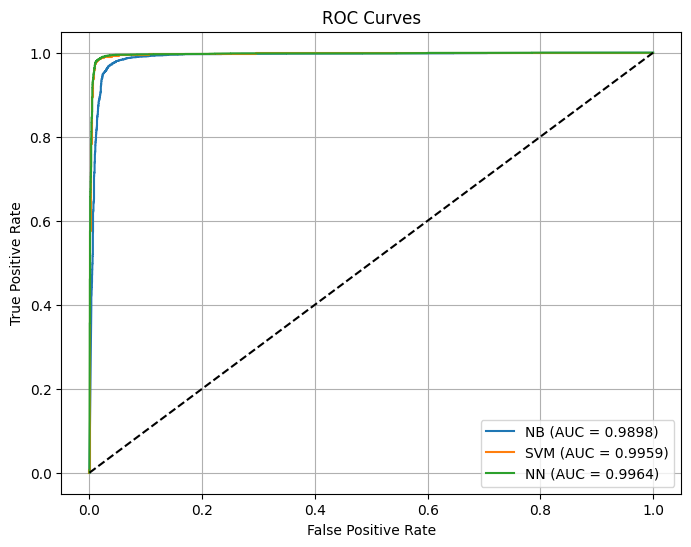

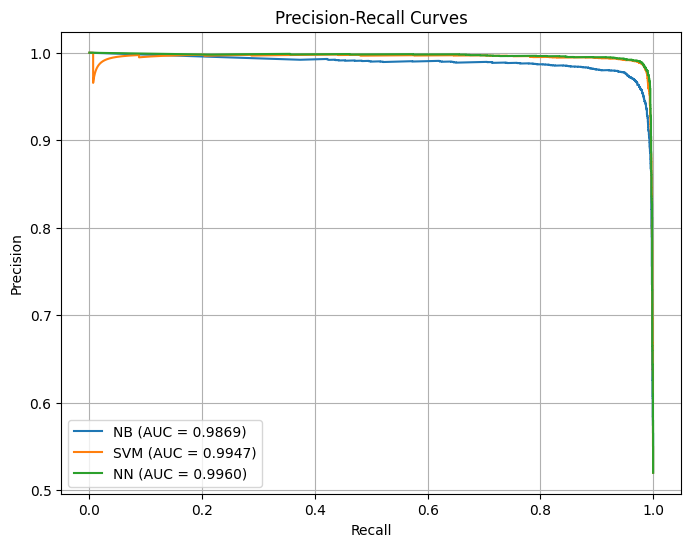

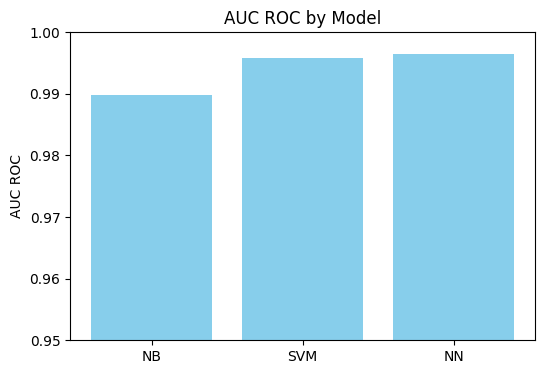

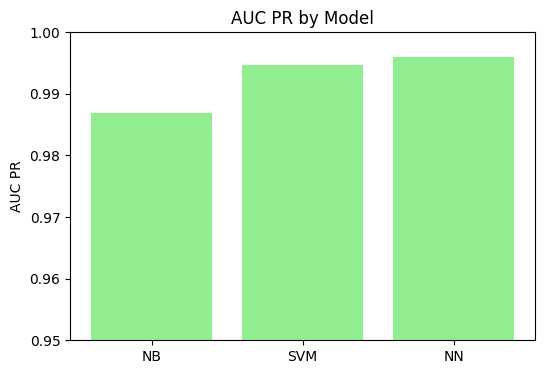

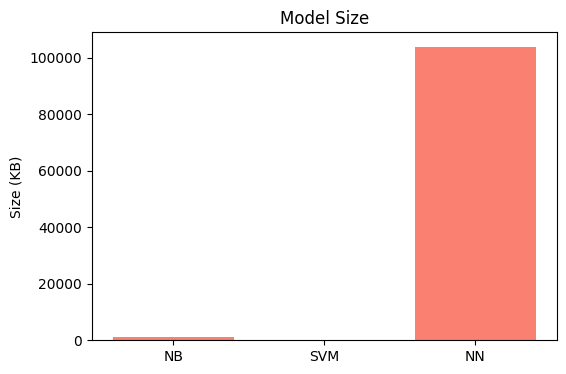

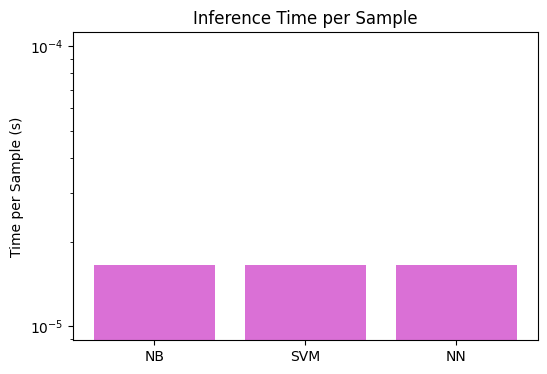

In [39]:
# Bar chart of accuracy, precision, recall, f1
x = np.arange(len(models))
width = 0.2
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
plt.bar(x - 0.5*width, precisions, width, label='Precision')
plt.bar(x + 0.5*width, recalls, width, label='Recall')
plt.bar(x + 1.5*width, f1_scores, width, label='F1 Score')
plt.xticks(x, models)
plt.ylabel('Score')
plt.ylim(0.93, 1.0)
plt.title('Performance Metrics')
plt.legend()
plt.show()

# ROC Curves
plt.figure(figsize=(8, 6))
for model in models:
    if roc_curves[model] is not None:
        fpr, tpr = roc_curves[model]
        plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_aucs[models.index(model)]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid()
plt.show()

# PR Curves
plt.figure(figsize=(8, 6))
for model in models:
    if pr_curves[model] is not None:
        recall, precision = pr_curves[model]
        plt.plot(recall, precision, label=f'{model} (AUC = {pr_aucs[models.index(model)]:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid()
plt.show()

# AUC ROC bar chart
plt.figure(figsize=(6, 4))
plt.bar(models, roc_aucs, color='skyblue')
plt.ylabel('AUC ROC')
plt.ylim(0.95, 1.0)
plt.title('AUC ROC by Model')
plt.show()

# AUC PR bar chart
plt.figure(figsize=(6, 4))
plt.bar(models, pr_aucs, color='lightgreen')
plt.ylabel('AUC PR')
plt.ylim(0.95, 1.0)
plt.title('AUC PR by Model')
plt.show()

# Size bar chart
plt.figure(figsize=(6, 4))
plt.bar(models, sizes, color='salmon')
plt.ylabel('Size (KB)')
plt.title('Model Size')
plt.show()

# Time per sample
plt.figure(figsize=(6, 4))
plt.yscale('log')
plt.bar(models, time_per_sample, color='orchid')
plt.ylabel('Time per Sample (s)')
plt.title('Inference Time per Sample')
plt.show()